##### Thursday the 25th of July, 2024
# Predicting Churn Risk in Customers of a Video Streaming Service
---

## Introduction
### Background

Subscription services are leveraged by companies across many industries, from fitness to video streaming to retail. One of the primary objectives of companies with subscription services is to decrease churn and ensure that users are retained as subscribers as it is more costly to procure new customers than to retain exsisting ones. 

Subscription cancellation can happen for a multitude of reasons, including:
* the customer completes all content they were interested in, and no longer need the subscription
* the customer finds themselves to be too busy and cancels their subscription until a later time
* the customer determines that the streaming service is not the best fit for them, so they cancel and look for something better suited

Regardless the reason for cancelling a subscription, this video streaming company has a vested interest in understanding the likelihood of each individual customer to churn in their subscription so that resources can be allocated appropriately to support customers. In order to do this efficiently and systematically, companies employ machine learning to predict which users are at the highest risk of churn.

### Objective

 The goal of this project is to develop a reliable machine learning model that can predict which existing subscribers will continue their subscriptions for another month, so that proper interventions can be effectively deployed to the right audience. In other words, using the patterns found in the `train.csv` data, we will predict whether the subscriptions in `test.csv` will be continued for another month, or not.

----


## Dataset description
The dataset used in this project is a sample of subscriptions initiated in 2021, all snapshotted at a particular date before the subscription was cancelled. The data is split 70/30 into a training set and a test set, which contain 243,787 and 104,480 entries, respectively.

Both `train.csv` and `test.csv` contain one row per unique subscription. For each subscription, a (`CustomerID`) identifier column is included. In addition to this identifier column, the `train.csv` dataset also contains the target variable, a binary column `Churn`.

Both datasets have an identical set of features. Descriptions of each feature are shown below.

In [1]:
import pandas as pd

data_descriptions = pd.read_csv("data_descriptions.csv")
pd.set_option("display.max_colwidth", None)
data_descriptions

,Column_name,Column_type,Data_type,Description
0,AccountAge,Feature,integer,The age of the user's account in months.
1,MonthlyCharges,Feature,float,The amount charged to the user on a monthly basis.
2,TotalCharges,Feature,float,The total charges incurred by the user over the account's lifetime.
3,SubscriptionType,Feature,object,"The type of subscription chosen by the user (Basic, Standard, or Premium)."
4,PaymentMethod,Feature,string,The method of payment used by the user.
5,PaperlessBilling,Feature,string,Indicates whether the user has opted for paperless billing (Yes or No).
6,ContentType,Feature,string,"The type of content preferred by the user (Movies, TV Shows, or Both)."
7,MultiDeviceAccess,Feature,string,Indicates whether the user has access to the service on multiple devices (Yes or No).
8,DeviceRegistered,Feature,string,"The type of device registered by the user (TV, Mobile, Tablet, or Computer)."
9,ViewingHoursPerWeek,Feature,float,The number of hours the user spends watching content per week.


---
## Import Python Modules

First, we import the libraries/modules that will be used in this project:

- pandas
- numpy
- matplotlib
- seaborn
- Scikit-learn

In [2]:
# Import required packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

---
## Load the Data

Let's start by loading the dataset `train.csv` into a dataframe `train_df`, and `test.csv` into a dataframe `test_df`

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

Next, we will print the first 5 rows of each data frame

In [4]:
print("Training data frame shape:", train_df.shape)
train_df.head()

Training data frame shape: (243787, 21)


,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,...,ContentDownloadsPerMonth,GenrePreference,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled,CustomerID,Churn
0,20,11.055215,221.104302,Premium,Mailed check,No,Both,No,Mobile,36.758104,...,10,Sci-Fi,2.176498,4,Male,3,No,No,CB6SXPNVZA,0
1,57,5.175208,294.986882,Basic,Credit card,Yes,Movies,No,Tablet,32.450568,...,18,Action,3.478632,8,Male,23,No,Yes,S7R2G87O09,0
2,73,12.106657,883.785952,Basic,Mailed check,Yes,Movies,No,Computer,7.395160,...,23,Fantasy,4.238824,6,Male,1,Yes,Yes,EASDC20BDT,0
3,32,7.263743,232.439774,Basic,Electronic check,No,TV Shows,No,Tablet,27.960389,...,30,Drama,4.276013,2,Male,24,Yes,Yes,NPF69NT69N,0
4,57,16.953078,966.325422,Premium,Electronic check,Yes,TV Shows,No,TV,20.083397,...,20,Comedy,3.616170,4,Female,0,No,No,4LGYPK7VOL,0


In [5]:
print("Test data frame shape:", test_df.shape)
test_df.head()

Test data frame shape: (104480, 20)


,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,GenrePreference,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled,CustomerID
0,38,17.869374,679.036195,Premium,Mailed check,No,TV Shows,No,TV,29.126308,122.274031,42,Comedy,3.522724,2,Male,23,No,No,O1W6BHP6RM
1,77,9.912854,763.289768,Basic,Electronic check,Yes,TV Shows,No,TV,36.873729,57.093319,43,Action,2.021545,2,Female,22,Yes,No,LFR4X92X8H
2,5,15.019011,75.095057,Standard,Bank transfer,No,TV Shows,Yes,Computer,7.601729,140.414001,14,Sci-Fi,4.806126,2,Female,22,No,Yes,QM5GBIYODA
3,88,15.357406,1351.451692,Standard,Electronic check,No,Both,Yes,Tablet,35.586430,177.002419,14,Comedy,4.943900,0,Female,23,Yes,Yes,D9RXTK2K9F
4,91,12.406033,1128.949004,Standard,Credit card,Yes,TV Shows,Yes,Tablet,23.503651,70.308376,6,Drama,2.846880,6,Female,0,No,No,ENTCCHR1LR


### Summary Statistics

Now, we will return summary statistics for our training data set

First, the count, mean, standard deviation, minimum, maximum, and 25th, 50th, and 75th percentiles of all numeric variables:

In [6]:
train_df.describe()

,AccountAge,MonthlyCharges,TotalCharges,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,UserRating,SupportTicketsPerMonth,WatchlistSize,Churn
count,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000
mean,60.083758,12.490695,750.741017,20.502179,92.264061,24.503513,3.002713,4.504186,12.018508,0.181232
std,34.285143,4.327615,523.073273,11.243753,50.505243,14.421174,1.155259,2.872548,7.193034,0.385211
min,1.000000,4.990062,4.991154,1.000065,5.000547,0.000000,1.000007,0.000000,0.000000,0.000000
25%,30.000000,8.738543,329.147027,10.763953,48.382395,12.000000,2.000853,2.000000,6.000000,0.000000
50%,60.000000,12.495555,649.878487,20.523116,92.249992,24.000000,3.002261,4.000000,12.000000,0.000000
75%,90.000000,16.238160,1089.317362,30.219396,135.908048,37.000000,4.002157,7.000000,18.000000,0.000000
max,119.000000,19.989957,2378.723844,39.999723,179.999275,49.000000,4.999989,9.000000,24.000000,1.000000


Now, the count, unique count, top class, and frequency of top class for all categorical variables:

In [7]:
train_df.describe(include = 'object')

,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,GenrePreference,Gender,ParentalControl,SubtitlesEnabled,CustomerID
count,243787,243787,243787,243787,243787,243787,243787,243787,243787,243787,243787
unique,3,4,2,3,2,4,5,2,2,2,243787
top,Standard,Electronic check,No,Both,No,Computer,Comedy,Female,Yes,Yes,CB6SXPNVZA
freq,81920,61313,121980,81737,122035,61147,49060,121930,122085,122180,1


Let's look at the column names and data type of each column in our data frame

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243787 entries, 0 to 243786
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   AccountAge                243787 non-null  int64  
 1   MonthlyCharges            243787 non-null  float64
 2   TotalCharges              243787 non-null  float64
 3   SubscriptionType          243787 non-null  object 
 4   PaymentMethod             243787 non-null  object 
 5   PaperlessBilling          243787 non-null  object 
 6   ContentType               243787 non-null  object 
 7   MultiDeviceAccess         243787 non-null  object 
 8   DeviceRegistered          243787 non-null  object 
 9   ViewingHoursPerWeek       243787 non-null  float64
 10  AverageViewingDuration    243787 non-null  float64
 11  ContentDownloadsPerMonth  243787 non-null  int64  
 12  GenrePreference           243787 non-null  object 
 13  UserRating                243787 non-null  f

Lastly, let's verify there are no missing values in our data:

In [9]:
train_df.isna().any()

AccountAge                  False
MonthlyCharges              False
TotalCharges                False
SubscriptionType            False
PaymentMethod               False
PaperlessBilling            False
ContentType                 False
MultiDeviceAccess           False
DeviceRegistered            False
ViewingHoursPerWeek         False
AverageViewingDuration      False
ContentDownloadsPerMonth    False
GenrePreference             False
UserRating                  False
SupportTicketsPerMonth      False
Gender                      False
WatchlistSize               False
ParentalControl             False
SubtitlesEnabled            False
CustomerID                  False
Churn                       False
dtype: bool

---
## Exploratory Data Analysis

### Distributions of Numeric Features
To visualize the distribution of each numeric feature, we plot a histogram matrix
#### Plotting Histogram Matrix

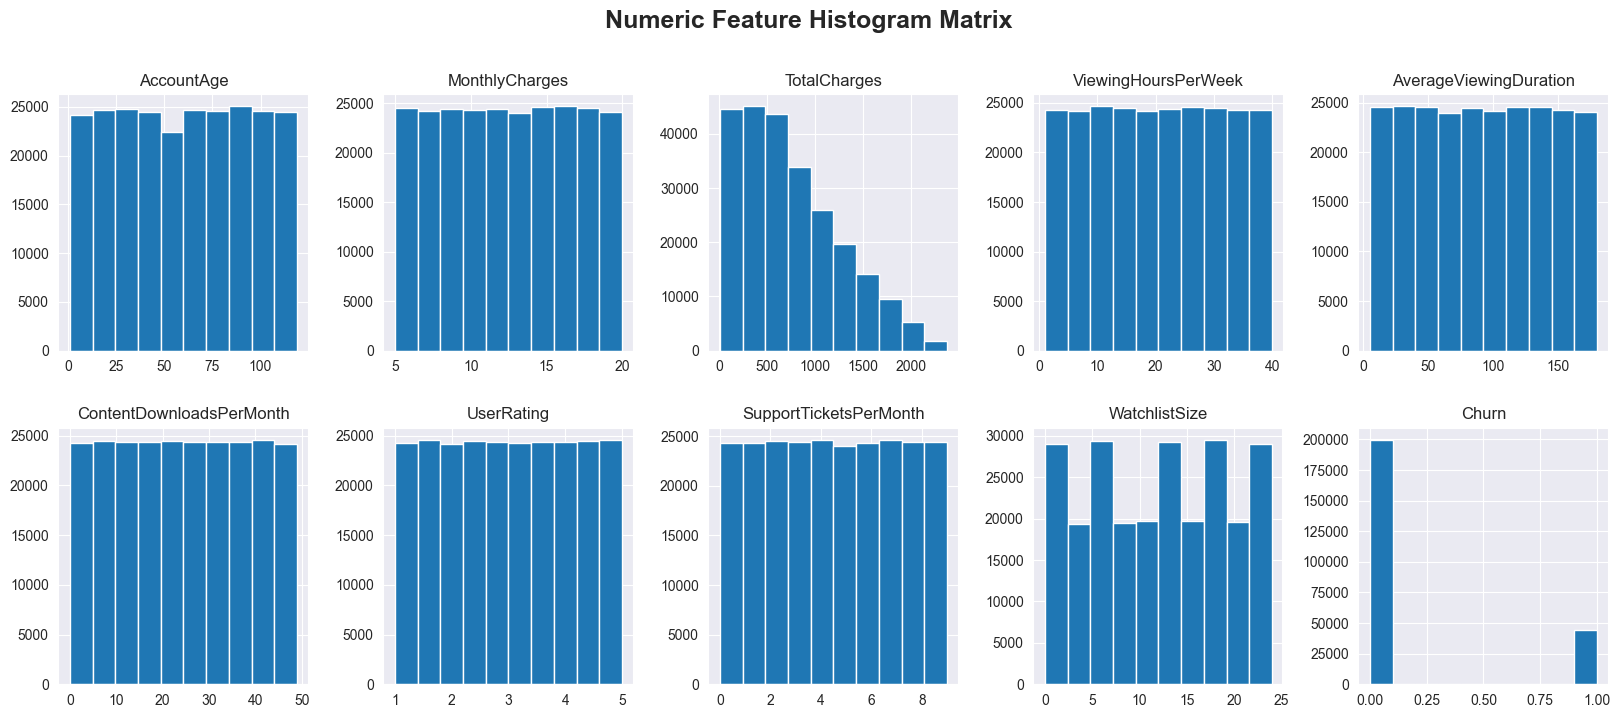

In [10]:
# Creating numeric feature data frame and list
numeric_features = train_df.select_dtypes(["integer", "float"])
numeric_features_list = list(numeric_features)
numeric_features_index = [train_df.columns.get_loc(c) for c in numeric_features_list if c in train_df]
numeric_features_index
# Creating histogram grid
numeric_features.hist(figsize=(20, 12), layout=(3, 5))
plt.suptitle("Numeric Feature Histogram Matrix", fontsize = 18, fontweight = "bold", y = 0.95)
plt.show()

### Distributions of Categorical Features

#### Plotting Countplot Grid

To simplify the following visualizations, we make a list of numeric and categorical features.

In [11]:
# List of numeric features column names
numeric_features = train_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_features.remove('Churn')

# List of categorical features column names
categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('CustomerID') 

# List of binary features column names
binary_features = []
for feature in categorical_features:
    if train_df[feature].nunique() == 2:
        binary_features.append(feature)

Now, we create a function to make the countplot grid

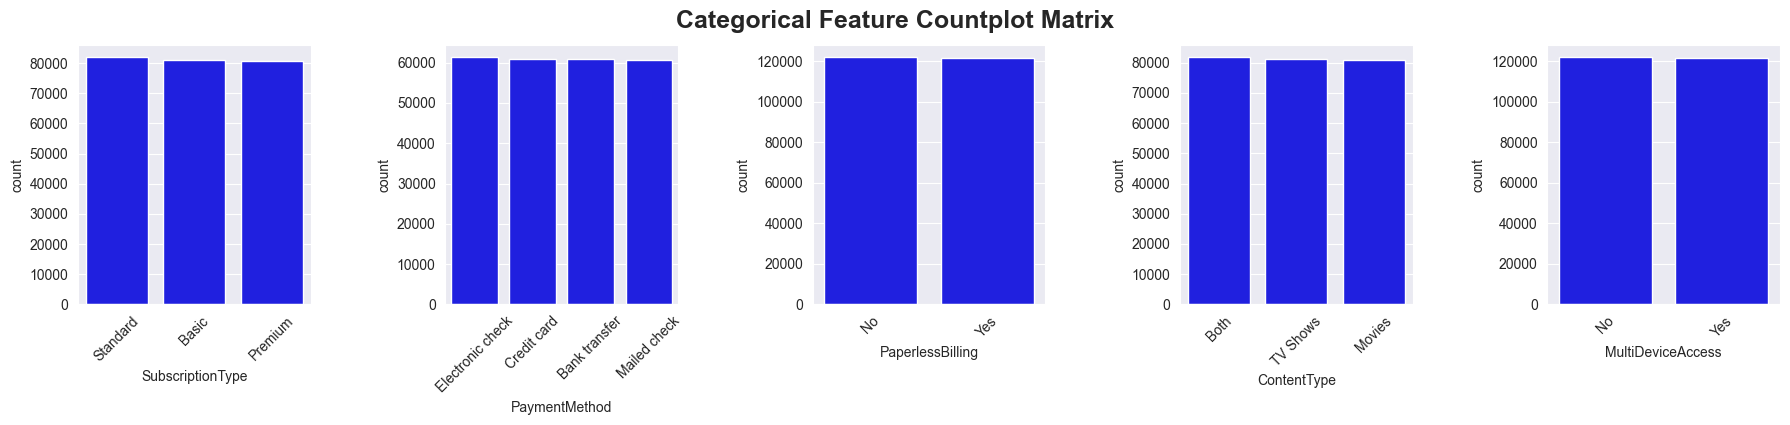

In [12]:
# Countplot function
def make_countplot(features_list):
    i = 0
    for n in range(0, 5):
        a = sns.countplot(
            ax=axes[n],
            x=features_list[i],
            data=train_df,
            color="blue",
            order=train_df[features_list[i]].value_counts().index,
        )
        a.tick_params(axis="x", labelrotation=45)
        i += 1

# Figure dimensions
fig, axes = plt.subplots(1, 5, figsize=(18, 4))

# Plot categorical countplot matrix
make_countplot(categorical_features)

# Adjust layout for subplot spacing
plt.tight_layout(w_pad=4, h_pad=6)
plt.suptitle("Categorical Feature Countplot Matrix", fontsize = 18, fontweight = "bold", y = 1.05);

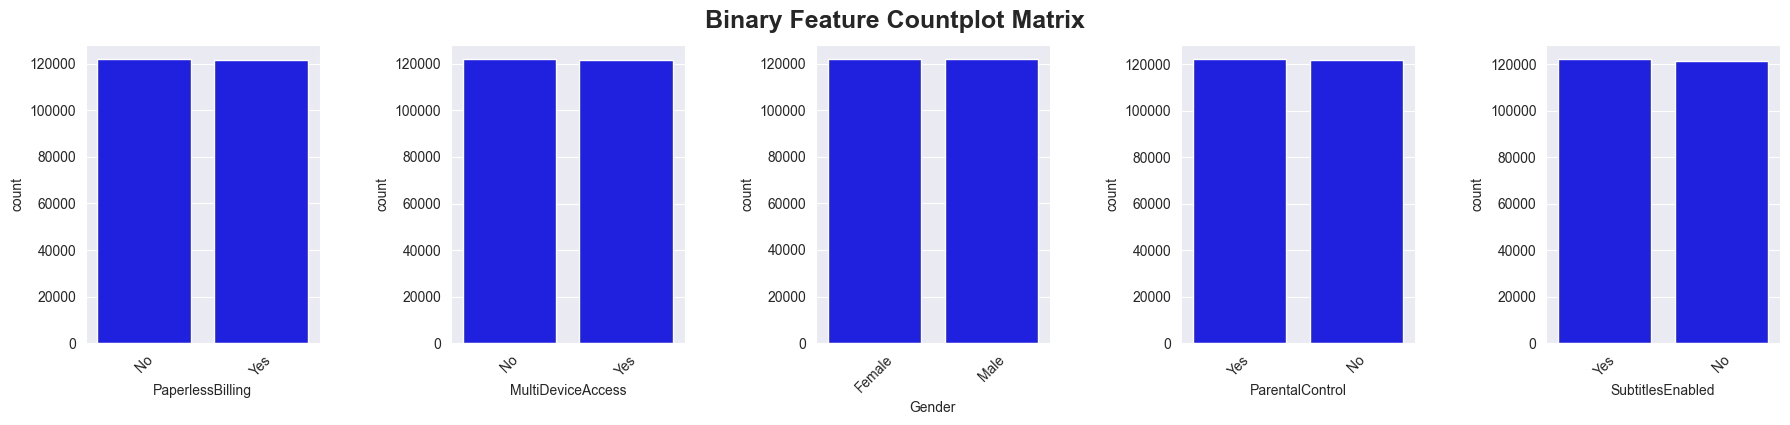

In [13]:
# Figure dimensions
fig, axes = plt.subplots(1, 5, figsize=(18, 4))

# Plot binary countplot matrix
make_countplot(binary_features)

# Adjust layout for subplot spacing
plt.tight_layout(w_pad=4, h_pad=6)
plt.suptitle("Binary Feature Countplot Matrix", fontsize = 18, fontweight = "bold", y = 1.05);

### Bivariate Visualization of Categorical Variables
To visualize the relationship between each categorical variable and churn distribution, we plot grouped bar plots depicting both the counts, and percentage of churn in each class of each categorical variable. We do the same separately below for two-class (binary) categorical variables. 

We define a function to facilitate plotting the aforementioned grouped bar plots:

In [14]:
# Creating grouped bar plot function
def grouped_plot(group_col):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    labels = ["Y", "N"]
    grouped = train_df.groupby(group_col)["Churn"].agg(Count="value_counts")
    # Calculate count
    count = grouped.pivot_table(values="Count", index=group_col, columns=["Churn"])
    count.plot(kind="bar", color=["#2e9624", "#eb2d46"], rot=0, ax=ax1)
    # Create count plot
    ax1.set_title("Churn Risk (Count)", fontsize=13, pad=10)
    ax1.set_ylabel("Count", size=10)
    ax1.legend(labels=labels, loc="upper right", title="Renew")
    # Calculate percentage
    perc = grouped.groupby(level=[0]).apply(lambda g: round(g * 100 / g.sum(), 2))
    perc.rename(columns={"Count": "Percentage"}, inplace=True)
    perc = perc.pivot_table(values="Percentage", index=group_col, columns=["Churn"])
    # Create percentage plot
    perc.plot(kind="bar", color=["#2e9624", "#eb2d46"], rot=0, ax=ax2)
    ax2.set_title("Churn Risk (Percentage)", fontsize=13, pad=10)
    ax2.set_ylabel("Percentage", size=10)
    ax2.legend(labels=labels, loc="upper right", title="Renew")

    # Add data labels
    for ax in (ax1, ax2):
        for i in range(0, 2):
            ax.bar_label(ax.containers[i], label_type="edge", fontsize=9)
    plt.suptitle("Churn Distribution by " + str(group_col), fontsize=16, fontweight = "bold")
    plt.tight_layout(rect=[0, 0, 1, 1])

#### Visualizing Categorical Feature Churn Distribution

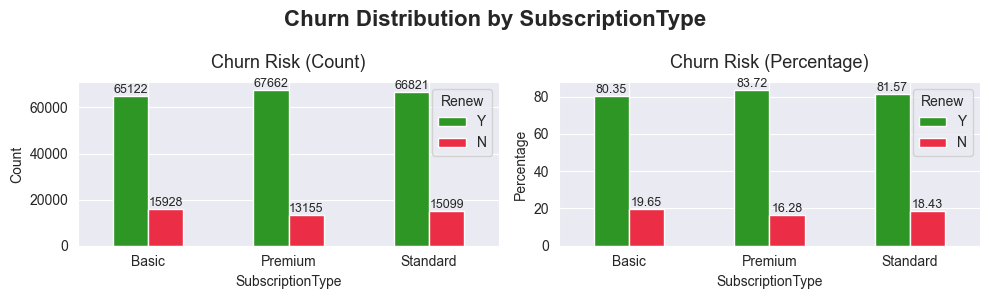

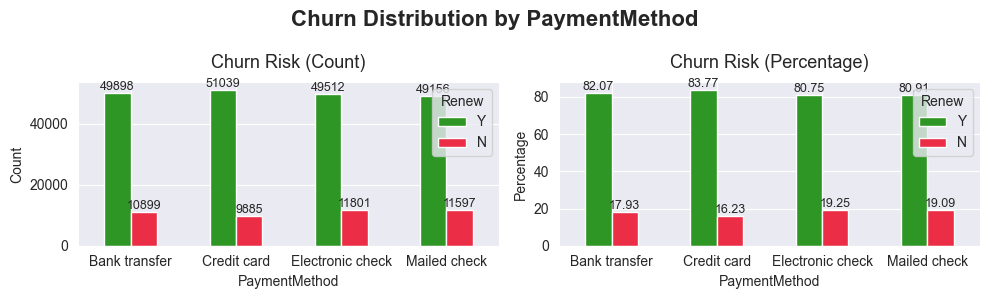

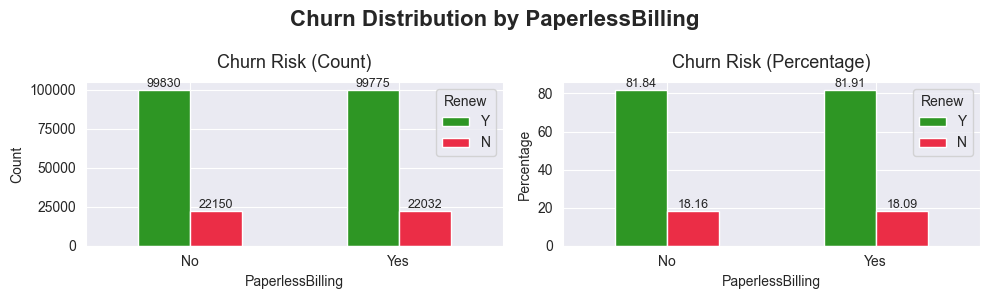

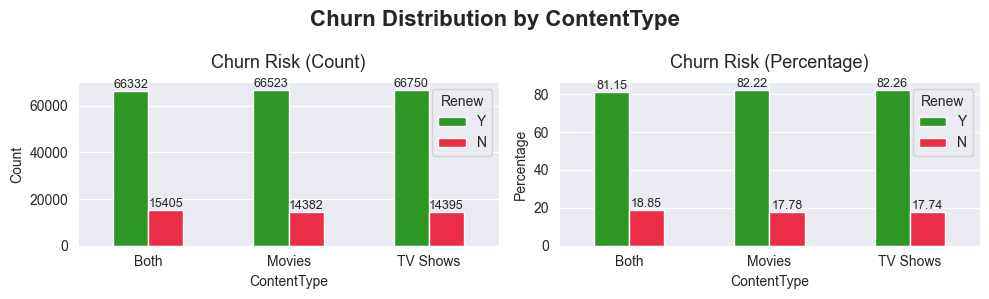

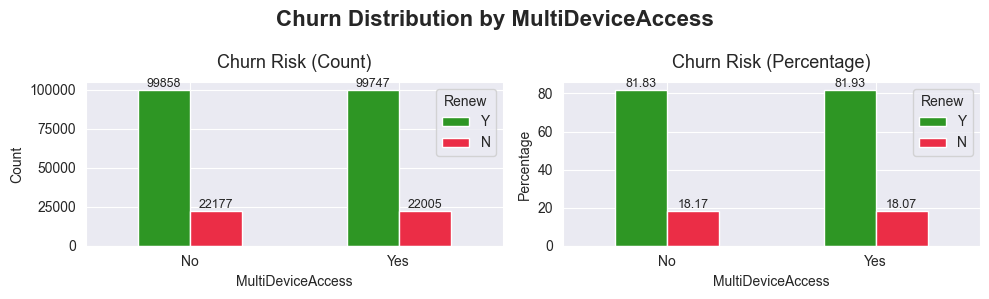

In [15]:
for i in range(0, 5):
    grouped_plot(categorical_features[i])

#### Visualizing Binary Feature Churn Distribution


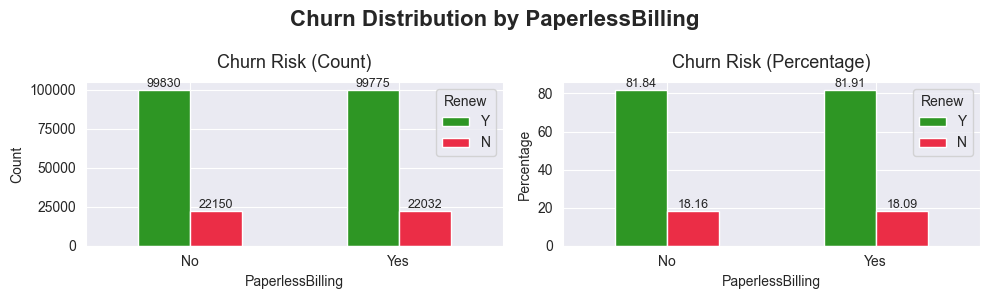

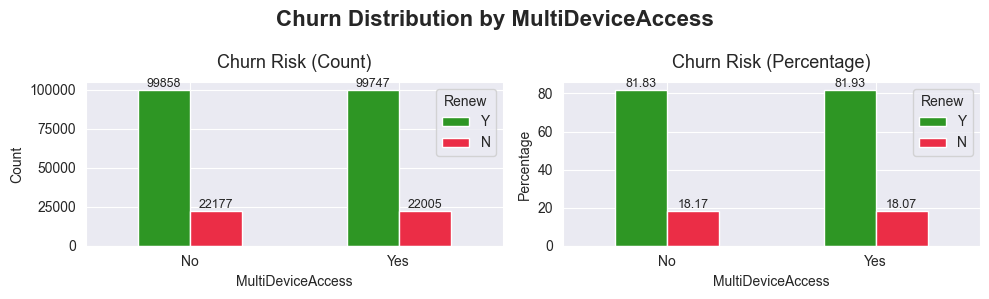

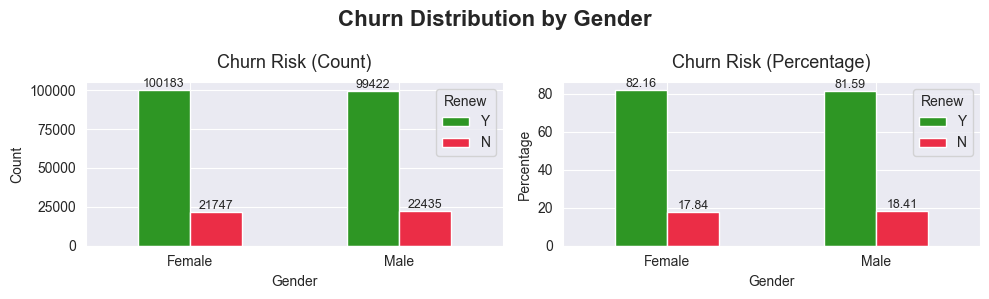

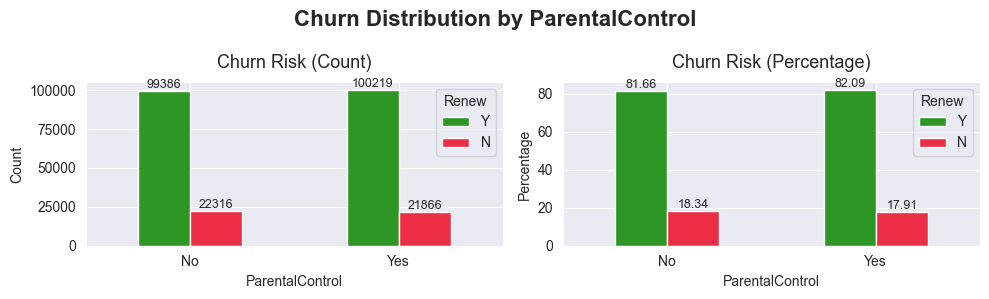

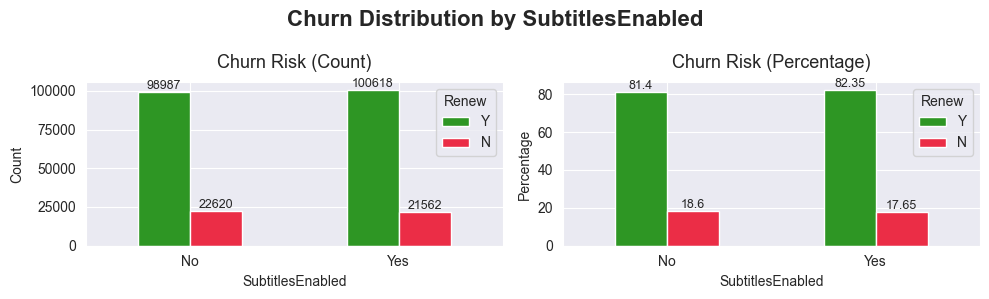

In [16]:
for i in range(0, 5):
    grouped_plot(binary_features[i])

### Multivariate Visualization of Numeric Variables
#### Correlations
To visualize the interactions between numeric variables (i.e., their correlations), we perform correlation analysis and plot a correlation matrix of the 9 numeric features. 

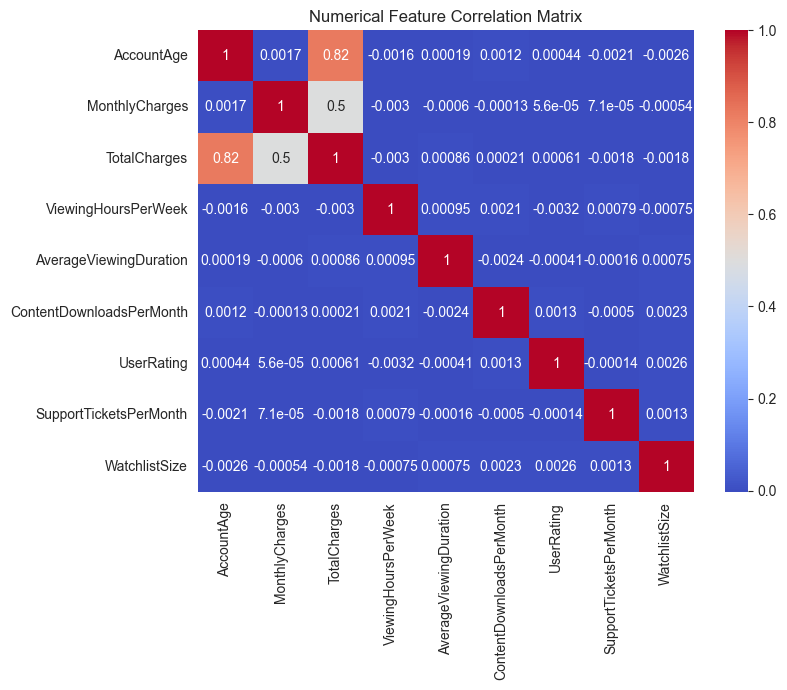

In [17]:
# Perform correlation analysis for numerical features
correlation_matrix = train_df[numeric_features].corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Numerical Feature Correlation Matrix')
plt.show()

## Feature Importance

Using `RandomForestClassifier()` and `.feature_importances_`, we determine the importance of each of our features to help us decide which we should include in our model.

In [18]:
# Use RandomForestClassifier to find feature importance for numerical and categorical features
rfc = RandomForestClassifier()

# Encode categorical features
encoded_cat = pd.get_dummies(train_df, columns=categorical_features, drop_first=True).drop(['Churn', 'CustomerID'], axis=1)
labels = train_df['Churn']

# Fit the model
rfc.fit(encoded_cat, labels)

# Get feature importances
importances = rfc.feature_importances_

# Creating a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': encoded_cat.columns, 'Importance': importances})

# Displaying feature importances
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df.head(10)  # Displaying top 10 features

,Feature,Importance
4,AverageViewingDuration,0.110392
3,ViewingHoursPerWeek,0.105436
1,MonthlyCharges,0.097541
2,TotalCharges,0.095759
0,AccountAge,0.095485
6,UserRating,0.086648
5,ContentDownloadsPerMonth,0.081936
8,WatchlistSize,0.062802
7,SupportTicketsPerMonth,0.046897
17,MultiDeviceAccess_Yes,0.013968


## Data Preprocessing
Before building our models, we must convert our features to appropriate formats. We begin by filtering our top features as determined by feature importance above.

In [19]:
# Filter top features
top_features = feature_importance_df.head(10)['Feature'].tolist()
filtered_numeric_columns = [col for col in numeric_features if col in top_features]
filtered_categorical_columns = [col for col in categorical_features if col in top_features]

Then, we create transformers for categorical and numeric data, and combine them using `ColumnTransformer()` to create our preprocessor. 

In [20]:
# Create transformers for preprocessing
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numeric_transformer = StandardScaler()

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, filtered_categorical_columns),
        ('num', numeric_transformer, filtered_numeric_columns)
    ]
)

## Model Building
Next, we define Logistic Regression, K-Nearest Neighbours, and Random Forest pipelines to transform the features using our pre-defined preprocessor. 

### Logistic Regression

In [21]:
# Create a logistic regression pipeline with preprocessing
lr_model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression())])

### K Nearest Neigbours

In [22]:
# Create a KNN classifier pipeline with preprocessing
knn_model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', KNeighborsClassifier())])

### Random Forest Classifier

In [23]:
random_forest_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier())]
)

---
## Cross Validation

### Preparing Feature, Target Data

Before we perform cross validation to score our models, we must create separate data frames for the features and target. We also filter the training and test data by our selected features. 

In [24]:
# Selected features
selected_features = [feature for feature in top_features if feature in train_df.columns]

# Splitting training features, target; filtering by selected features
X_train = train_df[selected_features]
y_train = train_df['Churn']

# Filtering test data frame by selected features
X_test = test_df[selected_features]

In [25]:
# Cross-validation
lr_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='roc_auc')
knn_scores = cross_val_score(knn_model, X_train, y_train, cv=5, scoring='roc_auc')
rfc_scores = cross_val_score(random_forest_model, X_train, y_train, cv=5, scoring='roc_auc')

# Calculate the average performance across the folds
lr_performance = lr_scores.mean()
knn_performance = knn_scores.mean()
rfc_performance = rfc_scores.mean()

print("Logistic Regression ROC-AUC:", lr_performance)
print("KNN ROC-AUC:", knn_performance)
print("Random Forest ROC-AUC:", rfc_performance)

Logistic Regression ROC-AUC: 0.7465650106544565
KNN ROC-AUC: 0.6436138327547012
Random Forest ROC-AUC: 0.7193026207435685


The top performing model based on ROC-AUC score is Logistic Regression, followed by Random Forest, then K-Nearest Neighbours. Based on these metrics, we opt to use the logistic regression model for our predictive analysis. 


---
## Predictions

We now fit our logistic regression model to our training data, then use `.predict_proba()` to predict the churn probability for each `CustomerID`. The predicted values are stored in the newly created `prediction_df` data frame. Lastly, we print the first 10 rows of the data frame to get a quick look at our predicted probabilities.

In [26]:
# Fitting the model
lr_model.fit(X_train, y_train)

# Making predictions on the test set
predicted_probabilities = lr_model.predict_proba(X_test)[:, 1]
predicted_probabilities

# Creating predicted values dataframe
prediction_df = pd.DataFrame({
    'CustomerID': test_df['CustomerID'],
    'predicted_probability': predicted_probabilities
})

# Return first 10 rows of predicted values
print("Predicted probability of churn by CustomerID:")
prediction_df.head(10)

Predicted probability of churn by CustomerID:


,CustomerID,predicted_probability
0,O1W6BHP6RM,0.103661
1,LFR4X92X8H,0.039467
2,QM5GBIYODA,0.400630
3,D9RXTK2K9F,0.038432
4,ENTCCHR1LR,0.150761
5,7A88BB5IO6,0.392558
6,70OMW9XEWR,0.116946
7,EL1RMFMPYL,0.240051
8,4IA2QPT6ZK,0.186936
9,AEDCWHSJDN,0.181187


## Discussion

The churn probabilities provided by the model developed in this project will allow for the video streaming service to identify "high-risk" customers and thereby allocate it's customer retention resources more efficiently. For example, the company may wish to offer personalized deals or improved service to those at risk of leaving. This may not only result in reduced churn, but also an improved customer experience, which can attract new customers through positive word-of-mouth. Another way in which churn probabilities can ***improve customer experience*** is by allowing for improved customer segmentation, enhancing tailored marketing strategies and product offerings.

From a financial standpoint, the identification and targeting of high-risk customers (churn management) ***increases ROI*** and ***stabilizes revenue***. Accurate churn predictions also aid in financial forecasting and planning, helping make more informed investment decisions, which provides a ***competitive advantage*** in the long run.